In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

In [2]:
#import movies 
movies = pd.read_csv('~/Documents/GitHub/Recommendation predict/datasets/movies.csv')
#import train data as ratings
ratings = pd.read_csv('~/Documents/GitHub/Recommendation predict/datasets/train.csv')

Lets preview the dataframes

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


**DATA ANALYSIS**

Lets analyze the data first to understand what we are working with.

To Start the analysis, lets first take a subset of users and check their likings

**2 Genre Analysis**

In [3]:
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    
    genre_ratings.columns = column_names
    #print(genre_ratings)
    return genre_ratings

In [4]:
ratings_twogenre = get_genre_ratings(ratings, movies, ['Crime', 'Thriller'], ['avg_crime_rating', 'avg_thriller_rating'])
ratings_twogenre.head()

,avg_crime_rating,avg_thriller_rating
1,4.12,5.00
2,2.39,3.77
3,3.91,3.65
4,3.68,3.20
5,4.25,3.82


Now that we have a filtered dataframe showing average ratings for the two Genres, lets refine the data a bit more to keep only users who liked one of the Genre more than other.

In [5]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_crime_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_thriller_rating'] > score_limit_2)) | ((genre_ratings['avg_thriller_rating'] < score_limit_1) & (genre_ratings['avg_crime_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

In [6]:
refined_dataset_twogenre = bias_genre_rating_dataset(ratings_twogenre, 3.5, 2.5)
refined_dataset_twogenre.head()

,index,avg_crime_rating,avg_thriller_rating
0,2,2.39,3.77
1,4,3.68,3.20
2,7,3.00,3.00
3,12,3.57,3.17
4,18,3.15,3.66


Lets draw a scatter plot to understand the data distribution for each of the users

In [7]:
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

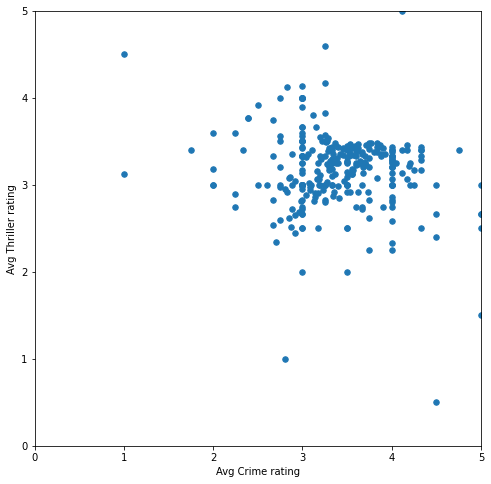

In [8]:
draw_scatterplot(refined_dataset_twogenre['avg_crime_rating'],'Avg Crime rating', refined_dataset_twogenre['avg_thriller_rating'], 'Avg Thriller rating')

Based on the data view above, we can see clear boundaries between user's ratings. Lets try to get clusters from this data using K-Means

In [8]:
X = refined_dataset_twogenre[['avg_crime_rating','avg_thriller_rating']].values
from sklearn.cluster import KMeans
kmeans_two_genre = KMeans(n_clusters=2, random_state=0)
predictions1 = kmeans_two_genre.fit_predict(X)

Lets plot the clusters to have a better view

In [9]:
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg Crime rating')
    ax.set_ylabel('Avg Thriller rating')
    

    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_crime_rating'], clustered['avg_thriller_rating'], c=clustered['group'], s=20, cmap=cmap)

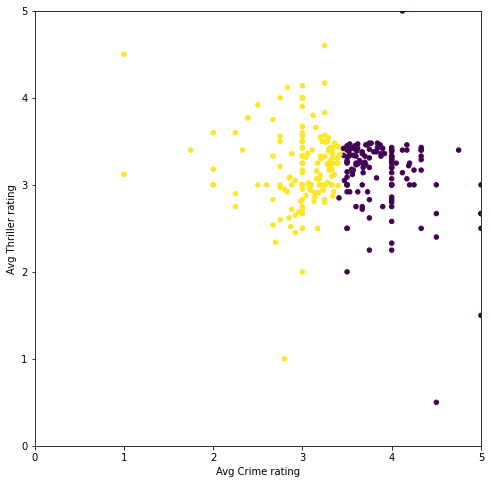

In [11]:
draw_clusters(refined_dataset_twogenre, predictions1)

So here we can see the data being divided into thwo groups/clusters:

- Users liking Crime genre
- Users liking Thriller genre

Lets try to break the data into one more cluster

In [10]:
kmeans_two_genre1 = KMeans(n_clusters=3, random_state=1)
predictions2 = kmeans_two_genre1.fit_predict(X)

Lets plot the clusters to have a better view

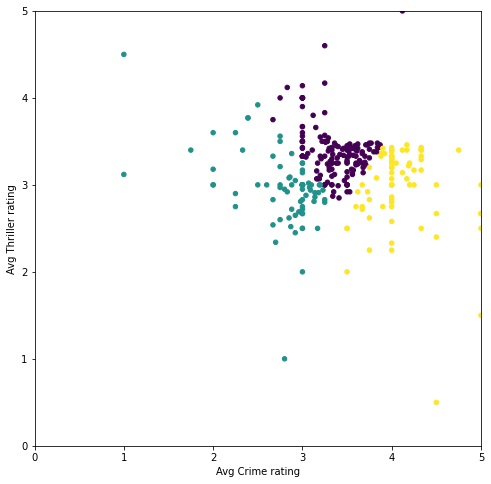

In [13]:
draw_clusters(refined_dataset_twogenre, predictions2)

Now we see one more group added. So with the new clustering we have:

- Users who like crime but not Thriller
- Users who like Thriller but not crime
- Users who like both

Lets add one more cluster and see the effect

In [11]:
kmeans_two_genre2 = KMeans(n_clusters=4, random_state=1)
predictions3 = kmeans_two_genre2.fit_predict(X)

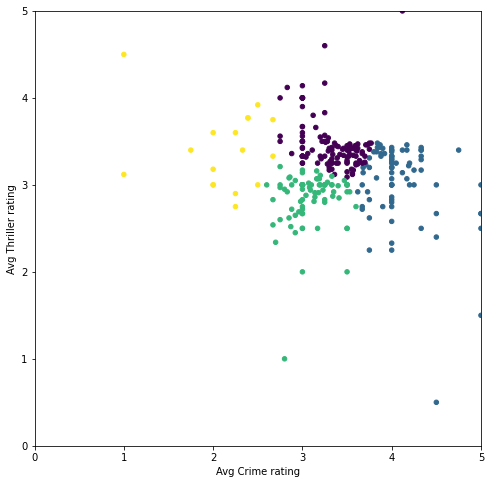

In [15]:
draw_clusters(refined_dataset_twogenre, predictions3)

So we can keep on adding clusters and refining the data groups from our dataset. The clusters accurately divide the users based on their likings(from ratings). But whats the optimum value for K or number of clusters. Lets figure that out

**Select K or number of clusters**

To get the correct value for K(# of clusters), lets perform the above steps for a range of K values and plot the errors for each. We will use the Elbow Method to choose the K value.

In [12]:
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

In [13]:
list_of_k = range(2, len(X)+1, 5)

# Calculate error values for all above
errors_list = [clustering_errors(k, X) for k in list_of_k]

<ipython-input-12-1c788f15ad74>:2: ConvergenceWarning: Number of distinct clusters (255) found smaller than n_clusters (257). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)
<ipython-input-12-1c788f15ad74>:2: ConvergenceWarning: Number of distinct clusters (255) found smaller than n_clusters (262). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)
<ipython-input-12-1c788f15ad74>:2: ConvergenceWarning: Number of distinct clusters (255) found smaller than n_clusters (267). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)
<ipython-input-12-1c788f15ad74>:2: ConvergenceWarning: Number of distinct clusters (255) found smaller than n_clusters (272). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)
<ipython-input-12-1c788f15ad74>:2: ConvergenceWarning: Number of distinct clusters (255) found smaller than n_clusters (277). Possibly due to duplicate points in X.
  kmean

Now lets plot the errors to have a visual. The optimum K value will be where the score (Y axis) have seemingly higher values.

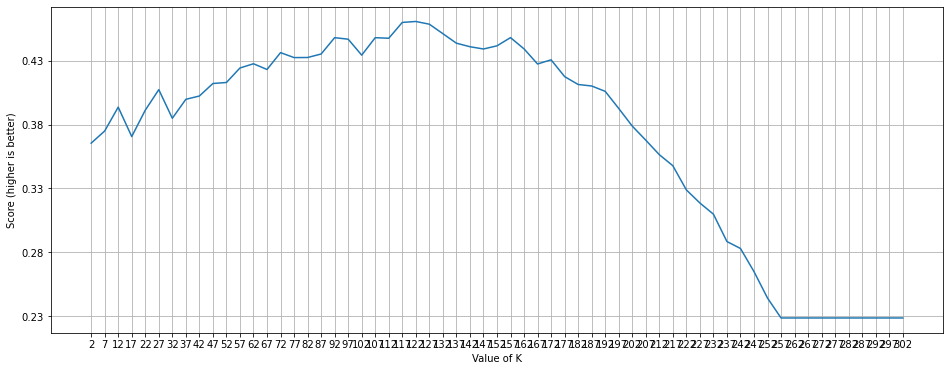

In [14]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('Value of K')
ax.set_ylabel('Score (higher is better)')
ax.plot(list_of_k, errors_list)

# Ticks and grid
xticks = np.arange(min(list_of_k), max(list_of_k)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_list), 2), max(errors_list), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

From the graph we can see possible K values can be 12,32,42,52,67,92 amongst other values. After these the score really dips a lot and we wont be going further down.

Lets pick K as 22 and perform the predictions.

In [15]:
kmeans_two_genre3 = KMeans(n_clusters=12, random_state=6)

# TODO: use fit_predict to cluster the dataset
predictions4 = kmeans_two_genre3.fit_predict(X)

Lets see how it looks now

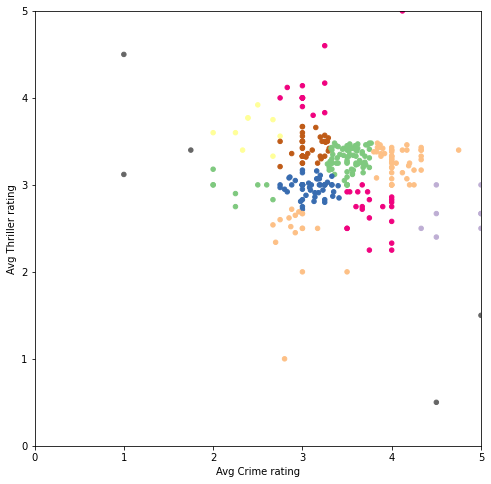

In [16]:
draw_clusters(refined_dataset_twogenre, predictions4, cmap='Accent')

**Lets add one more Genre**

Lets add Science-fiction(sci-fi) as another genre and perform the similar analysis as above.

In [17]:
refined_dataset_3genre = get_genre_ratings(ratings, movies, 
                                                     ['Crime', 'Thriller', 'Sci-Fi'], 
                                                     ['avg_crime_rating', 'avg_thriller_rating', 'avg_sci-fi_rating'])
refined_dataset_3genre = bias_genre_rating_dataset(refined_dataset_3genre, 3.5, 2.5).dropna()
refined_dataset_3genre.head()

,index,avg_crime_rating,avg_thriller_rating,avg_sci-fi_rating
0,2,2.39,3.77,3.86
1,4,3.68,3.20,3.00
3,12,3.57,3.17,3.06
4,18,3.15,3.66,3.65
5,19,3.28,3.03,3.66


In [18]:
X_sci_fi = refined_dataset_3genre[['avg_crime_rating', 'avg_thriller_rating', 'avg_sci-fi_rating']].values

With the new dataset, lets do a prediction using 12 clusters.

In [19]:
kmeans_three_genre1 = KMeans(n_clusters=12)
predictions_1_1 = kmeans_three_genre1.fit_predict(X_sci_fi)

Lets see how this looks now with 3 genres.

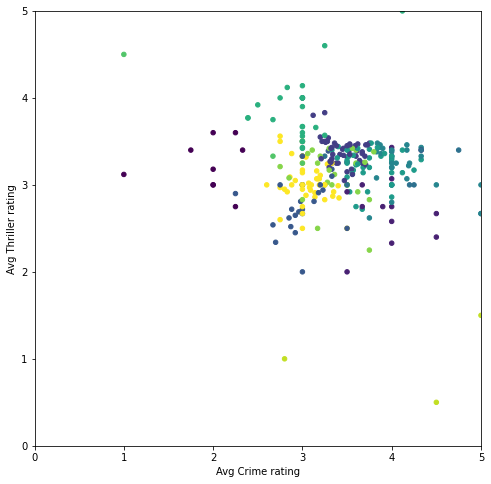

In [20]:
draw_clusters(refined_dataset_3genre, predictions_1_1)

The 3D cluster is not really visible on the above plot. Let's try to create 3D  visualization.

In [21]:
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg Crime rating')
    ax.set_ylabel('Avg Thriller rating')

    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_sci-fi_rating'].astype(float) > 3: 
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_crime_rating'], 
                        point['avg_thriller_rating'], 
                        s=size, 
                        color=color)

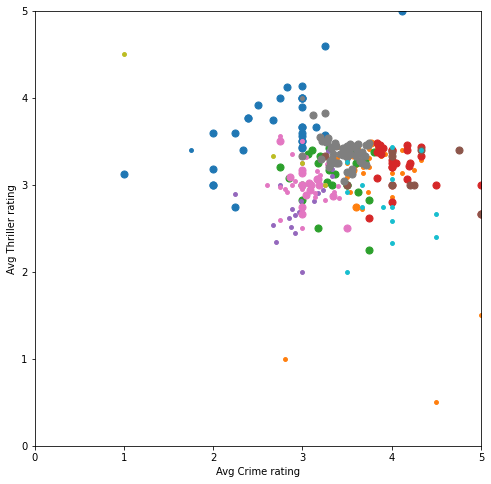

In [22]:
draw_clusters_3d(refined_dataset_3genre, predictions_1_1)

Now we can see how the clusters have changed. As the data input increases, the clusters become more refined. We wont add any more genres for now.

**Cluster the Movies based on ratings**

Now that we have seen how we can cluster based on Genres, lets change our approach and build the clusters based on user ratings on the movies.

**Prepare the dataset**

First we transform the input data so that its easier to view/analyze the ratings across users and movies. We will build a pivot table showing users and their ratings for each movie.

In [23]:
ratings_df = ratings.sample(n=10000)
ratings_df.head()

,userId,movieId,rating,timestamp
3520650,132522,36529,3.0,1214762678
756133,5320,1036,5.0,1553979295
1736028,64254,3178,5.0,956616325
3793388,11417,2716,3.0,1426619699
5508324,129559,73323,3.0,1420169917


A previous attempt to pivot the table resulted in error:"Unstacked DataFrame is too big, causing int32 overflow", hence we created a sample of 10000 for each.

In [24]:
titles_df = pd.merge(ratings_df, movies[['movieId', 'title']], on='movieId' )
titles_df.head()

,userId,movieId,rating,timestamp,title
0,132522,36529,3.0,1214762678,Lord of War (2005)
1,113127,36529,5.0,1208805512,Lord of War (2005)
2,150889,36529,3.5,1145476732,Lord of War (2005)
3,22891,36529,4.0,1439578699,Lord of War (2005)
4,119674,36529,4.0,1565457098,Lord of War (2005)


In [25]:
ratings_users = pd.pivot_table(titles_df, index='userId', columns= 'title', values='rating')
ratings_users.iloc[:5]

title,"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),...,Zeitgeist: The Movie (2007),Zero Dark Thirty (2012),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),[REC] (2007),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that majority of the ratings are NA and understandable because not all users have rated all movies. So lets sort the data to have the most rated ones first.

In [26]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

In [27]:
def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

In [28]:
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

In [29]:
# shrinking the dataset for better visualization
num_movies = 30
num_users = 18
most_rated_sorted = sort_by_rating_density(ratings_users, num_movies, num_users)
most_rated_sorted.head()

title,Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Independence Day (a.k.a. ID4) (1996),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),Terminator 2: Judgment Day (1991),Schindler's List (1993),Star Wars: Episode IV - A New Hope (1977),Twister (1996),...,True Lies (1994),Gladiator (2000),Léon: The Professional (a.k.a. The Professional) (Léon) (1994),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Babe (1995),Braveheart (1995),Forrest Gump (1994),"Fugitive, The (1993)","Lord of the Rings: The Return of the King, The (2003)",Ace Ventura: Pet Detective (1994)
4148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
1850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8467,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN
1163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN


We can almost see few ratings but the table still dominated by NaN values, we will visualize the data in a heatmap to identify rating clusters.

In [30]:
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()

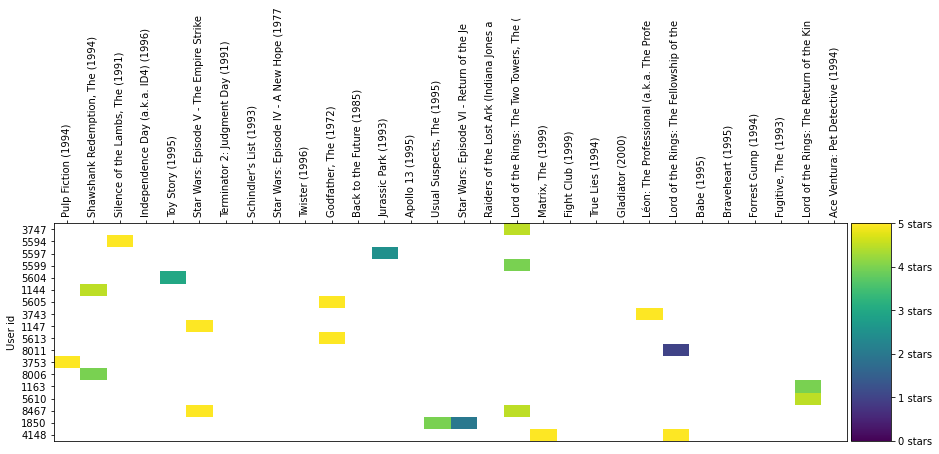

In [31]:
draw_movies_heatmap(most_rated_sorted)

This shows a visual of how users rated the movies. The white cells are when users didnt rate that movie. We handle this next.

For next steps, to have proper performance for this post, let me filter the dataset and work with a smaller dataset.

In [32]:
ratings_df_subset =  pd.pivot_table(titles_df, index='userId', columns= 'title', values='rating')
filtered_most_rated = get_most_rated_movies(ratings_df_subset, 2000)

**Get the Sparse matrix**

But the problem still remains where there are NA values in the dataset. To get around this, I will convert the dataset to sparse csr matrix.

In [33]:
# Remove all nulls
tmpmovies=filtered_most_rated.copy()
tmpmovies=tmpmovies.fillna(0)
dtcols=filtered_most_rated.columns
tmpdict={}
for v in dtcols:
    tmpdict[v]=pd.arrays.SparseArray(tmpmovies[v])
sparseFrame=pd.DataFrame(tmpdict)
sparse_ratings = csr_matrix(sparseFrame)

Now that we have the Sparse matrix for the ratings, lets perform some predictions.

**Perform Predictions**

In [ ]:
new_k_values = range(2, 100+1, 5)
sparse_errors_k = [clustering_errors(k, sparse_ratings) for k in new_k_values]

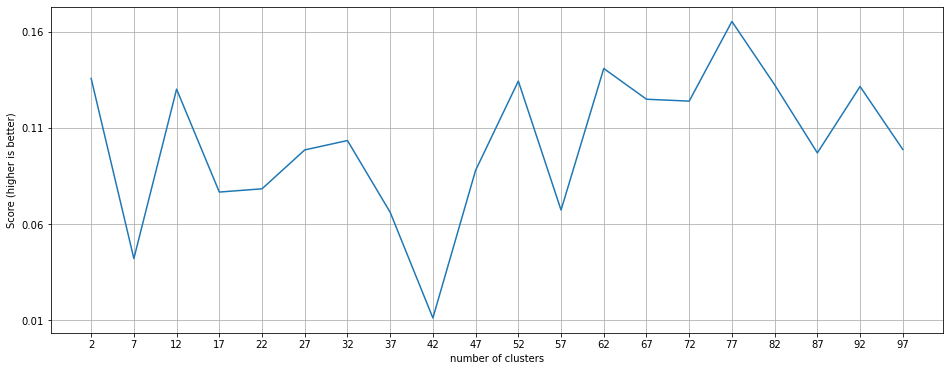

In [32]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('number of clusters')
ax.set_ylabel('Score (higher is better)')
ax.plot(new_k_values, sparse_errors_k)


xticks = np.arange(min(new_k_values), max(new_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(sparse_errors_k), 2), max(sparse_errors_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

looking at this graph its a bit undecisive regarding which value to take for K. Lets select one of 2,7,12,17,22,32, 42,47,52...

we choose k as 52

In [45]:
predictions_sparse_1 = KMeans(n_clusters=22, algorithm='full').fit_predict(sparse_ratings)

Lets visualize some of the clusters from above.

In [46]:
predict_cluster = pd.concat([filtered_most_rated.reset_index(), pd.DataFrame({'group':predictions_sparse_1})], axis=1)
predict_cluster.head()

,index,"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Braveheart (1995),Star Wars: Episode V - The Empire Strikes Back (1980),Fight Club (1999),Star Wars: Episode IV - A New Hope (1977),"Matrix, The (1999)",Back to the Future (1985),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),...,Compliance (2012),Renaissance Man (1994),Richie Rich (1994),Cloudy with a Chance of Meatballs 2 (2013),Clockwatchers (1997),Rififi (Du rififi chez les hommes) (1955),Circle (2015),Rock Star (2001),Rock 'N' Roll High School (1979),group
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [47]:
predict_cluster.tail(20)

,index,"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Braveheart (1995),Star Wars: Episode V - The Empire Strikes Back (1980),Fight Club (1999),Star Wars: Episode IV - A New Hope (1977),"Matrix, The (1999)",Back to the Future (1985),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),...,Compliance (2012),Renaissance Man (1994),Richie Rich (1994),Cloudy with a Chance of Meatballs 2 (2013),Clockwatchers (1997),Rififi (Du rififi chez les hommes) (1955),Circle (2015),Rock Star (2001),Rock 'N' Roll High School (1979),group
8974,8974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8975,8975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8976,8976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8977,8977,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
8978,8978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8979,8979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8980,8980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8981,8981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8982,8982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8983,8983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


The group column shows which cluster group the user belongs to based on the ratings. Now that we have the clustered dataset, lets see what type of predictions we can perform for this.

**Predictions from the cluster**

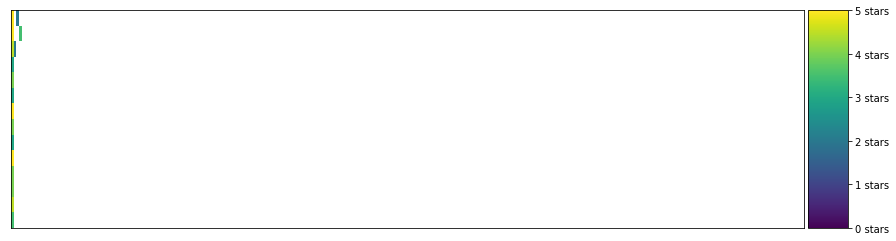

In [41]:
cluster_id = 5
newnum_users = 70
newnum_movies = 300
cluster_1 = predict_cluster[predict_cluster.group == cluster_id].drop(['index', 'group'], axis=1)
cluster_1 = sort_by_rating_density(cluster_1, newnum_movies, newnum_users)
draw_movies_heatmap(cluster_1, axis_labels=False)

This shows little to no results from our predictions, which in the previous it was observed that most of the data belong to 1 cluster and others were NaN. and we cannot go further training the model with the full dataset. The error faced is the one of memory allocation of the large data failed to be brought to memory to pivot the dataframe.

- another factor affecting our model, is the size of the subset does not qualify to be a representation of the full dataset.
- Given the growth in the number of movies in all genre, our model will fail in the near future.